# FloPy

## Creating a Complex MODFLOW 6 Model with Flopy

The purpose of this notebook is to demonstrate the Flopy capabilities for building a more complex MODFLOW 6 model from scratch.  This notebook will demonstrate the capabilities by replicating the advgw_tidal model that is distributed with MODFLOW 6.

### Setup the Notebook Environment

In [1]:
import sys
import os
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.7.15 (default, Oct 18 2022, 09:36:49) 
[GCC 11.2.0]
numpy version: 1.21.6
matplotlib version: 3.5.3
flopy version: 3.3.6


In [2]:
# For this example, we will set up a temporary workspace.
# Model input files and output files will reside here.
temp_dir = TemporaryDirectory()
model_name = "advgw_tidal"
workspace = os.path.join(temp_dir.name, model_name)

In [3]:
data_pth = os.path.join(
    "..", "data", "mf6", "create_tests", "test005_advgw_tidal"
)
assert os.path.isdir(data_pth)

In [4]:
# create simulation
sim = flopy.mf6.MFSimulation(
    sim_name=model_name, version="mf6", exe_name="mf6", sim_ws=workspace
)

# create tdis package
tdis_rc = [(1.0, 1, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0)]
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=4, perioddata=tdis_rc
)

# create gwf model
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=model_name, model_nam_file="{}.nam".format(model_name)
)
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    print_option="SUMMARY",
    complexity="SIMPLE",
    outer_dvclose=0.0001,
    outer_maximum=500,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=0.0001,
    rcloserecord=0.001,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.97,
)
sim.register_ims_package(ims, [gwf.name])

In [5]:
# discretization package
nlay = 3
nrow = 15
ncol = 10
botlay2 = {"factor": 1.0, "data": [-100 for x in range(150)]}
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=500.0,
    delc=500.0,
    top=50.0,
    botm=[5.0, -10.0, botlay2],
    filename="{}.dis".format(model_name),
)

# initial conditions
ic = flopy.mf6.ModflowGwfic(
    gwf, pname="ic", strt=50.0, filename="{}.ic".format(model_name)
)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    pname="npf",
    save_flows=True,
    icelltype=[1, 0, 0],
    k=[5.0, 0.1, 4.0],
    k33=[0.5, 0.005, 0.1],
)

# output control
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord="{}.cbb".format(model_name),
    head_filerecord="{}.hds".format(model_name),
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "FIRST"), ("HEAD", "LAST"), ("BUDGET", "LAST")],
)

In [6]:
# storage package
sy = flopy.mf6.ModflowGwfsto.sy.empty(gwf, layered=True)
for layer in range(0, 3):
    sy[layer]["data"] = 0.2

ss = flopy.mf6.ModflowGwfsto.ss.empty(
    gwf, layered=True, default_value=0.000001
)

sto = flopy.mf6.ModflowGwfsto(
    gwf,
    pname="sto",
    save_flows=True,
    iconvert=1,
    ss=ss,
    sy=sy,
    steady_state={0: True},
    transient={1: True},
)

In [7]:
# well package
# test empty with aux vars, bound names, and time series
period_two = flopy.mf6.ModflowGwfwel.stress_period_data.empty(
    gwf,
    maxbound=3,
    aux_vars=["var1", "var2", "var3"],
    boundnames=True,
    timeseries=True,
)
period_two[0][0] = ((0, 11, 2), -50.0, -1, -2, -3, None)
period_two[0][1] = ((2, 4, 7), "well_1_rate", 1, 2, 3, "well_1")
period_two[0][2] = ((2, 3, 2), "well_2_rate", 4, 5, 6, "well_2")
period_three = flopy.mf6.ModflowGwfwel.stress_period_data.empty(
    gwf,
    maxbound=2,
    aux_vars=["var1", "var2", "var3"],
    boundnames=True,
    timeseries=True,
)
period_three[0][0] = ((2, 3, 2), "well_2_rate", 1, 2, 3, "well_2")
period_three[0][1] = ((2, 4, 7), "well_1_rate", 4, 5, 6, "well_1")
period_four = flopy.mf6.ModflowGwfwel.stress_period_data.empty(
    gwf,
    maxbound=5,
    aux_vars=["var1", "var2", "var3"],
    boundnames=True,
    timeseries=True,
)
period_four[0][0] = ((2, 4, 7), "well_1_rate", 1, 2, 3, "well_1")
period_four[0][1] = ((2, 3, 2), "well_2_rate", 4, 5, 6, "well_2")
period_four[0][2] = ((0, 11, 2), -10.0, 7, 8, 9, None)
period_four[0][3] = ((0, 2, 4), -20.0, 17, 18, 19, None)
period_four[0][4] = ((0, 13, 5), -40.0, 27, 28, 29, None)
stress_period_data = {}
stress_period_data[1] = period_two[0]
stress_period_data[2] = period_three[0]
stress_period_data[3] = period_four[0]
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    pname="wel",
    print_input=True,
    print_flows=True,
    auxiliary=[("var1", "var2", "var3")],
    maxbound=5,
    stress_period_data=stress_period_data,
    boundnames=True,
    save_flows=True,
)

# well ts package
ts_data = [
    (0.0, 0.0, 0.0, 0.0),
    (1.0, -200.0, 0.0, -100.0),
    (11.0, -1800.0, -500.0, -200.0),
    (21.0, -200.0, -400.0, -300.0),
    (31.0, 0.0, -600.0, -400.0),
]
wel.ts.initialize(
    filename="well-rates.ts",
    timeseries=ts_data,
    time_series_namerecord=[("well_1_rate", "well_2_rate", "well_3_rate")],
    interpolation_methodrecord=[("stepwise", "stepwise", "stepwise")],
)

In [8]:
# Evapotranspiration
evt_period = flopy.mf6.ModflowGwfevt.stress_period_data.empty(gwf, 150, nseg=3)
for col in range(0, 10):
    for row in range(0, 15):
        evt_period[0][col * 15 + row] = (
            (0, row, col),
            50.0,
            0.0004,
            10.0,
            0.2,
            0.5,
            0.3,
            0.1,
            None,
        )
evt = flopy.mf6.ModflowGwfevt(
    gwf,
    pname="evt",
    print_input=True,
    print_flows=True,
    save_flows=True,
    maxbound=150,
    nseg=3,
    stress_period_data=evt_period,
)

In [9]:
# General-Head Boundaries
ghb_period = {}
ghb_period_array = []
for layer, cond in zip(range(1, 3), [15.0, 1500.0]):
    for row in range(0, 15):
        ghb_period_array.append(((layer, row, 9), "tides", cond, "Estuary-L2"))
ghb_period[0] = ghb_period_array
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname="ghb",
    print_input=True,
    print_flows=True,
    save_flows=True,
    boundnames=True,
    maxbound=30,
    stress_period_data=ghb_period,
)
ts_recarray = []
fd = open(os.path.join(data_pth, "tides.txt"), "r")
for line in fd:
    line_list = line.strip().split(",")
    ts_recarray.append((float(line_list[0]), float(line_list[1])))
ghb.ts.initialize(
    filename="tides.ts",
    timeseries=ts_recarray,
    time_series_namerecord="tides",
    interpolation_methodrecord="linear",
)
obs_recarray = {
    "ghb_obs.csv": [
        ("ghb-2-6-10", "GHB", (1, 5, 9)),
        ("ghb-3-6-10", "GHB", (2, 5, 9)),
    ],
    "ghb_flows.csv": [
        ("Estuary2", "GHB", "Estuary-L2"),
        ("Estuary3", "GHB", "Estuary-L3"),
    ],
}
ghb.obs.initialize(
    filename="{}.ghb.obs".format(model_name),
    print_input=True,
    continuous=obs_recarray,
)

In [10]:
obs_recarray = {
    "head_obs.csv": [("h1_13_8", "HEAD", (2, 12, 7))],
    "intercell_flow_obs1.csv": [
        ("ICF1_1.0", "FLOW-JA-FACE", (0, 4, 5), (0, 5, 5))
    ],
    "head-hydrographs.csv": [
        ("h3-13-9", "HEAD", (2, 12, 8)),
        ("h3-12-8", "HEAD", (2, 11, 7)),
        ("h1-4-3", "HEAD", (0, 3, 2)),
        ("h1-12-3", "HEAD", (0, 11, 2)),
        ("h1-13-9", "HEAD", (0, 12, 8)),
    ],
}
obs_package = flopy.mf6.ModflowUtlobs(
    gwf,
    pname="head_obs",
    filename="{}.obs".format(model_name),
    print_input=True,
    continuous=obs_recarray,
)

In [11]:
# River
riv_period = {}
riv_period_array = [
    ((0, 2, 0), "river_stage_1", 1001.0, 35.9, None),
    ((0, 3, 1), "river_stage_1", 1002.0, 35.8, None),
    ((0, 4, 2), "river_stage_1", 1003.0, 35.7, None),
    ((0, 4, 3), "river_stage_1", 1004.0, 35.6, None),
    ((0, 5, 4), "river_stage_1", 1005.0, 35.5, None),
    ((0, 5, 5), "river_stage_1", 1006.0, 35.4, "riv1_c6"),
    ((0, 5, 6), "river_stage_1", 1007.0, 35.3, "riv1_c7"),
    ((0, 4, 7), "river_stage_1", 1008.0, 35.2, None),
    ((0, 4, 8), "river_stage_1", 1009.0, 35.1, None),
    ((0, 4, 9), "river_stage_1", 1010.0, 35.0, None),
    ((0, 9, 0), "river_stage_2", 1001.0, 36.9, "riv2_upper"),
    ((0, 8, 1), "river_stage_2", 1002.0, 36.8, "riv2_upper"),
    ((0, 7, 2), "river_stage_2", 1003.0, 36.7, "riv2_upper"),
    ((0, 6, 3), "river_stage_2", 1004.0, 36.6, None),
    ((0, 6, 4), "river_stage_2", 1005.0, 36.5, None),
    ((0, 5, 5), "river_stage_2", 1006.0, 36.4, "riv2_c6"),
    ((0, 5, 6), "river_stage_2", 1007.0, 36.3, "riv2_c7"),
    ((0, 6, 7), "river_stage_2", 1008.0, 36.2, None),
    ((0, 6, 8), "river_stage_2", 1009.0, 36.1),
    ((0, 6, 9), "river_stage_2", 1010.0, 36.0),
]
riv_period[0] = riv_period_array
riv = flopy.mf6.ModflowGwfriv(
    gwf,
    pname="riv",
    print_input=True,
    print_flows=True,
    save_flows="{}.cbc".format(model_name),
    boundnames=True,
    maxbound=20,
    stress_period_data=riv_period,
)
ts_recarray = [
    (0.0, 40.0, 41.0),
    (1.0, 41.0, 41.5),
    (2.0, 43.0, 42.0),
    (3.0, 45.0, 42.8),
    (4.0, 44.0, 43.0),
    (6.0, 43.0, 43.1),
    (9.0, 42.0, 42.4),
    (11.0, 41.0, 41.5),
    (31.0, 40.0, 41.0),
]
riv.ts.initialize(
    filename="river_stages.ts",
    timeseries=ts_recarray,
    time_series_namerecord=[("river_stage_1", "river_stage_2")],
    interpolation_methodrecord=[("linear", "stepwise")],
)
obs_recarray = {
    "riv_obs.csv": [
        ("rv1-3-1", "RIV", (0, 2, 0)),
        ("rv1-4-2", "RIV", (0, 3, 1)),
        ("rv1-5-3", "RIV", (0, 4, 2)),
        ("rv1-5-4", "RIV", (0, 4, 3)),
        ("rv1-6-5", "RIV", (0, 5, 4)),
        ("rv1-c6", "RIV", "riv1_c6"),
        ("rv1-c7", "RIV", "riv1_c7"),
        ("rv2-upper", "RIV", "riv2_upper"),
        ("rv-2-7-4", "RIV", (0, 6, 3)),
        ("rv2-8-5", "RIV", (0, 6, 4)),
        (
            "rv-2-9-6",
            "RIV",
            (
                0,
                5,
                5,
            ),
        ),
    ],
    "riv_flowsA.csv": [
        ("riv1-3-1", "RIV", (0, 2, 0)),
        ("riv1-4-2", "RIV", (0, 3, 1)),
        ("riv1-5-3", "RIV", (0, 4, 2)),
    ],
    "riv_flowsB.csv": [
        ("riv2-10-1", "RIV", (0, 9, 0)),
        ("riv-2-9-2", "RIV", (0, 8, 1)),
        ("riv2-8-3", "RIV", (0, 7, 2)),
    ],
}
riv.obs.initialize(
    filename="{}.riv.obs".format(model_name),
    print_input=True,
    continuous=obs_recarray,
)

In [12]:
# First recharge package
rch1_period = {}
rch1_period_array = []
col_range = {0: 3, 1: 4, 2: 5}
for row in range(0, 15):
    if row in col_range:
        col_max = col_range[row]
    else:
        col_max = 6
    for col in range(0, col_max):
        if (
            (row == 3 and col == 5)
            or (row == 2 and col == 4)
            or (row == 1 and col == 3)
            or (row == 0 and col == 2)
        ):
            mult = 0.5
        else:
            mult = 1.0
        if row == 0 and col == 0:
            bnd = "rch-1-1"
        elif row == 0 and col == 1:
            bnd = "rch-1-2"
        elif row == 1 and col == 2:
            bnd = "rch-2-3"
        else:
            bnd = None
        rch1_period_array.append(((0, row, col), "rch_1", mult, bnd))
rch1_period[0] = rch1_period_array
rch1 = flopy.mf6.ModflowGwfrch(
    gwf,
    filename="{}_1.rch".format(model_name),
    pname="rch_1",
    fixed_cell=True,
    auxiliary="MULTIPLIER",
    auxmultname="MULTIPLIER",
    print_input=True,
    print_flows=True,
    save_flows=True,
    boundnames=True,
    maxbound=84,
    stress_period_data=rch1_period,
)
ts_data = [
    (0.0, 0.0015),
    (1.0, 0.0010),
    (11.0, 0.0015),
    (21.0, 0.0025),
    (31.0, 0.0015),
]
rch1.ts.initialize(
    filename="recharge_rates_1.ts",
    timeseries=ts_data,
    time_series_namerecord="rch_1",
    interpolation_methodrecord="stepwise",
)

In [13]:
# Second recharge package
rch2_period = {}
rch2_period_array = [
    ((0, 0, 2), "rch_2", 0.5),
    ((0, 0, 3), "rch_2", 1.0),
    ((0, 0, 4), "rch_2", 1.0),
    ((0, 0, 5), "rch_2", 1.0),
    ((0, 0, 6), "rch_2", 1.0),
    ((0, 0, 7), "rch_2", 1.0),
    ((0, 0, 8), "rch_2", 1.0),
    ((0, 0, 9), "rch_2", 0.5),
    ((0, 1, 3), "rch_2", 0.5),
    ((0, 1, 4), "rch_2", 1.0),
    ((0, 1, 5), "rch_2", 1.0),
    ((0, 1, 6), "rch_2", 1.0),
    ((0, 1, 7), "rch_2", 1.0),
    ((0, 1, 8), "rch_2", 0.5),
    ((0, 2, 4), "rch_2", 0.5),
    ((0, 2, 5), "rch_2", 1.0),
    ((0, 2, 6), "rch_2", 1.0),
    ((0, 2, 7), "rch_2", 0.5),
    ((0, 3, 5), "rch_2", 0.5),
    ((0, 3, 6), "rch_2", 0.5),
]
rch2_period[0] = rch2_period_array
rch2 = flopy.mf6.ModflowGwfrch(
    gwf,
    filename="{}_2.rch".format(model_name),
    pname="rch_2",
    fixed_cell=True,
    auxiliary="MULTIPLIER",
    auxmultname="MULTIPLIER",
    print_input=True,
    print_flows=True,
    save_flows=True,
    maxbound=20,
    stress_period_data=rch2_period,
)
ts_data = [
    (0.0, 0.0016),
    (1.0, 0.0018),
    (11.0, 0.0019),
    (21.0, 0.0016),
    (31.0, 0.0018),
]
rch2.ts.initialize(
    filename="recharge_rates_2.ts",
    timeseries=ts_data,
    time_series_namerecord="rch_2",
    interpolation_methodrecord="linear",
)

In [14]:
# Third recharge package
rch3_period = {}
rch3_period_array = []
col_range = {0: 9, 1: 8, 2: 7}
for row in range(0, 15):
    if row in col_range:
        col_min = col_range[row]
    else:
        col_min = 6
    for col in range(col_min, 10):
        if (
            (row == 0 and col == 9)
            or (row == 1 and col == 8)
            or (row == 2 and col == 7)
            or (row == 3 and col == 6)
        ):
            mult = 0.5
        else:
            mult = 1.0
        rch3_period_array.append(((0, row, col), "rch_3", mult))
rch3_period[0] = rch3_period_array
rch3 = flopy.mf6.ModflowGwfrch(
    gwf,
    filename="{}_3.rch".format(model_name),
    pname="rch_3",
    fixed_cell=True,
    auxiliary="MULTIPLIER",
    auxmultname="MULTIPLIER",
    print_input=True,
    print_flows=True,
    save_flows=True,
    maxbound=54,
    stress_period_data=rch3_period,
)
ts_data = [
    (0.0, 0.0017),
    (1.0, 0.0020),
    (11.0, 0.0017),
    (21.0, 0.0018),
    (31.0, 0.0020),
]
rch3.ts.initialize(
    filename="recharge_rates_3.ts",
    timeseries=ts_data,
    time_series_namerecord="rch_3",
    interpolation_methodrecord="linear",
)

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [15]:
# write simulation to new location
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model advgw_tidal...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package wel...
    writing package ts_0...
    writing package evt...
    writing package ghb...
    writing package ts_1...
    writing package obs_0...
    writing package head_obs...
    writing package riv...
    writing package ts_2...
    writing package obs_1...
    writing package rch_1...
    writing package ts_3...
    writing package rch_2...
    writing package ts_4...
    writing package rch_3...
    writing package ts_5...


In [16]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['advgw_tidal.nam', 'advgw_tidal.ghb', 'advgw_tidal.obs', 'tides.ts', 'advgw_tidal.oc', 'advgw_tidal.riv.obs', 'advgw_tidal_3.rch', 'advgw_tidal.ims', 'advgw_tidal.ghb.obs', 'recharge_rates_3.ts', 'advgw_tidal.npf', 'advgw_tidal.evt', 'recharge_rates_2.ts', 'advgw_tidal.dis', 'advgw_tidal.riv', 'advgw_tidal.sto', 'river_stages.ts', 'advgw_tidal.tdis', 'advgw_tidal.wel', 'advgw_tidal_1.rch', 'advgw_tidal_2.rch', 'mfsim.nam', 'recharge_rates_1.ts', 'well-rates.ts', 'advgw_tidal.ic']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [17]:
# Run the simulation
success, buff = sim.run_simulation()
print("\nSuccess is: ", success)

FloPy is using the following executable to run the model: /home/runner/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Dec 10 2022 04:48:56 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Go

    Solving:  Stress period:     2    Time step:    18
    Solving:  Stress period:     2    Time step:    19
    Solving:  Stress period:     2    Time step:    20
    Solving:  Stress period:     2    Time step:    21
    Solving:  Stress period:     2    Time step:    22
    Solving:  Stress period:     2    Time step:    23
    Solving:  Stress period:     2    Time step:    24
    Solving:  Stress period:     2    Time step:    25
    Solving:  Stress period:     2    Time step:    26
    Solving:  Stress period:     2    Time step:    27
    Solving:  Stress period:     2    Time step:    28
    Solving:  Stress period:     2    Time step:    29
    Solving:  Stress period:     2    Time step:    30
    Solving:  Stress period:     2    Time step:    31
    Solving:  Stress period:     2    Time step:    32
    Solving:  Stress period:     2    Time step:    33
    Solving:  Stress period:     2    Time step:    34
    Solving:  Stress period:     2    Time step:    35
    Solvin

    Solving:  Stress period:     2    Time step:    43
    Solving:  Stress period:     2    Time step:    44
    Solving:  Stress period:     2    Time step:    45
    Solving:  Stress period:     2    Time step:    46
    Solving:  Stress period:     2    Time step:    47
    Solving:  Stress period:     2    Time step:    48
    Solving:  Stress period:     2    Time step:    49


    Solving:  Stress period:     2    Time step:    50
    Solving:  Stress period:     2    Time step:    51
    Solving:  Stress period:     2    Time step:    52
    Solving:  Stress period:     2    Time step:    53
    Solving:  Stress period:     2    Time step:    54
    Solving:  Stress period:     2    Time step:    55
    Solving:  Stress period:     2    Time step:    56
    Solving:  Stress period:     2    Time step:    57
    Solving:  Stress period:     2    Time step:    58
    Solving:  Stress period:     2    Time step:    59
    Solving:  Stress period:     2    Time step:    60
    Solving:  Stress period:     2    Time step:    61
    Solving:  Stress period:     2    Time step:    62
    Solving:  Stress period:     2    Time step:    63
    Solving:  Stress period:     2    Time step:    64
    Solving:  Stress period:     2    Time step:    65
    Solving:  Stress period:     2    Time step:    66
    Solving:  Stress period:     2    Time step:    67
    Solvin

    Solving:  Stress period:     2    Time step:    85
    Solving:  Stress period:     2    Time step:    86
    Solving:  Stress period:     2    Time step:    87
    Solving:  Stress period:     2    Time step:    88
    Solving:  Stress period:     2    Time step:    89
    Solving:  Stress period:     2    Time step:    90
    Solving:  Stress period:     2    Time step:    91
    Solving:  Stress period:     2    Time step:    92
    Solving:  Stress period:     2    Time step:    93
    Solving:  Stress period:     2    Time step:    94
    Solving:  Stress period:     2    Time step:    95
    Solving:  Stress period:     2    Time step:    96
    Solving:  Stress period:     2    Time step:    97
    Solving:  Stress period:     2    Time step:    98
    Solving:  Stress period:     2    Time step:    99
    Solving:  Stress period:     2    Time step:   100
    Solving:  Stress period:     2    Time step:   101
    Solving:  Stress period:     2    Time step:   102
    Solvin

    Solving:  Stress period:     2    Time step:   113
    Solving:  Stress period:     2    Time step:   114
    Solving:  Stress period:     2    Time step:   115
    Solving:  Stress period:     2    Time step:   116
    Solving:  Stress period:     2    Time step:   117
    Solving:  Stress period:     2    Time step:   118
    Solving:  Stress period:     2    Time step:   119


    Solving:  Stress period:     2    Time step:   120
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     3    Time step:     2
    Solving:  Stress period:     3    Time step:     3
    Solving:  Stress period:     3    Time step:     4
    Solving:  Stress period:     3    Time step:     5
    Solving:  Stress period:     3    Time step:     6
    Solving:  Stress period:     3    Time step:     7
    Solving:  Stress period:     3    Time step:     8
    Solving:  Stress period:     3    Time step:     9
    Solving:  Stress period:     3    Time step:    10
    Solving:  Stress period:     3    Time step:    11
    Solving:  Stress period:     3    Time step:    12
    Solving:  Stress period:     3    Time step:    13
    Solving:  Stress period:     3    Time step:    14
    Solving:  Stress period:     3    Time step:    15
    Solving:  Stress period:     3    Time step:    16
    Solving:  Stress period:     3    Time step:    17
    Solvin

    Solving:  Stress period:     3    Time step:    30
    Solving:  Stress period:     3    Time step:    31
    Solving:  Stress period:     3    Time step:    32
    Solving:  Stress period:     3    Time step:    33
    Solving:  Stress period:     3    Time step:    34
    Solving:  Stress period:     3    Time step:    35
    Solving:  Stress period:     3    Time step:    36
    Solving:  Stress period:     3    Time step:    37
    Solving:  Stress period:     3    Time step:    38
    Solving:  Stress period:     3    Time step:    39
    Solving:  Stress period:     3    Time step:    40
    Solving:  Stress period:     3    Time step:    41
    Solving:  Stress period:     3    Time step:    42
    Solving:  Stress period:     3    Time step:    43
    Solving:  Stress period:     3    Time step:    44
    Solving:  Stress period:     3    Time step:    45
    Solving:  Stress period:     3    Time step:    46
    Solving:  Stress period:     3    Time step:    47
    Solvin

    Solving:  Stress period:     3    Time step:    56
    Solving:  Stress period:     3    Time step:    57
    Solving:  Stress period:     3    Time step:    58
    Solving:  Stress period:     3    Time step:    59
    Solving:  Stress period:     3    Time step:    60
    Solving:  Stress period:     3    Time step:    61
    Solving:  Stress period:     3    Time step:    62


    Solving:  Stress period:     3    Time step:    63
    Solving:  Stress period:     3    Time step:    64
    Solving:  Stress period:     3    Time step:    65
    Solving:  Stress period:     3    Time step:    66
    Solving:  Stress period:     3    Time step:    67
    Solving:  Stress period:     3    Time step:    68
    Solving:  Stress period:     3    Time step:    69
    Solving:  Stress period:     3    Time step:    70
    Solving:  Stress period:     3    Time step:    71
    Solving:  Stress period:     3    Time step:    72
    Solving:  Stress period:     3    Time step:    73
    Solving:  Stress period:     3    Time step:    74
    Solving:  Stress period:     3    Time step:    75
    Solving:  Stress period:     3    Time step:    76
    Solving:  Stress period:     3    Time step:    77
    Solving:  Stress period:     3    Time step:    78
    Solving:  Stress period:     3    Time step:    79
    Solving:  Stress period:     3    Time step:    80
    Solvin

    Solving:  Stress period:     3    Time step:    95
    Solving:  Stress period:     3    Time step:    96
    Solving:  Stress period:     3    Time step:    97
    Solving:  Stress period:     3    Time step:    98
    Solving:  Stress period:     3    Time step:    99
    Solving:  Stress period:     3    Time step:   100
    Solving:  Stress period:     3    Time step:   101
    Solving:  Stress period:     3    Time step:   102
    Solving:  Stress period:     3    Time step:   103
    Solving:  Stress period:     3    Time step:   104
    Solving:  Stress period:     3    Time step:   105
    Solving:  Stress period:     3    Time step:   106
    Solving:  Stress period:     3    Time step:   107
    Solving:  Stress period:     3    Time step:   108
    Solving:  Stress period:     3    Time step:   109
    Solving:  Stress period:     3    Time step:   110
    Solving:  Stress period:     3    Time step:   111
    Solving:  Stress period:     3    Time step:   112
    Solvin

    Solving:  Stress period:     4    Time step:     1
    Solving:  Stress period:     4    Time step:     2
    Solving:  Stress period:     4    Time step:     3
    Solving:  Stress period:     4    Time step:     4
    Solving:  Stress period:     4    Time step:     5
    Solving:  Stress period:     4    Time step:     6


    Solving:  Stress period:     4    Time step:     7
    Solving:  Stress period:     4    Time step:     8
    Solving:  Stress period:     4    Time step:     9
    Solving:  Stress period:     4    Time step:    10
    Solving:  Stress period:     4    Time step:    11
    Solving:  Stress period:     4    Time step:    12
    Solving:  Stress period:     4    Time step:    13
    Solving:  Stress period:     4    Time step:    14
    Solving:  Stress period:     4    Time step:    15
    Solving:  Stress period:     4    Time step:    16
    Solving:  Stress period:     4    Time step:    17
    Solving:  Stress period:     4    Time step:    18
    Solving:  Stress period:     4    Time step:    19
    Solving:  Stress period:     4    Time step:    20
    Solving:  Stress period:     4    Time step:    21
    Solving:  Stress period:     4    Time step:    22
    Solving:  Stress period:     4    Time step:    23
    Solving:  Stress period:     4    Time step:    24
    Solvin

    Solving:  Stress period:     4    Time step:    41
    Solving:  Stress period:     4    Time step:    42
    Solving:  Stress period:     4    Time step:    43
    Solving:  Stress period:     4    Time step:    44
    Solving:  Stress period:     4    Time step:    45
    Solving:  Stress period:     4    Time step:    46
    Solving:  Stress period:     4    Time step:    47
    Solving:  Stress period:     4    Time step:    48
    Solving:  Stress period:     4    Time step:    49
    Solving:  Stress period:     4    Time step:    50
    Solving:  Stress period:     4    Time step:    51
    Solving:  Stress period:     4    Time step:    52
    Solving:  Stress period:     4    Time step:    53
    Solving:  Stress period:     4    Time step:    54
    Solving:  Stress period:     4    Time step:    55
    Solving:  Stress period:     4    Time step:    56
    Solving:  Stress period:     4    Time step:    57
    Solving:  Stress period:     4    Time step:    58
    Solvin

    Solving:  Stress period:     4    Time step:    67
    Solving:  Stress period:     4    Time step:    68
    Solving:  Stress period:     4    Time step:    69
    Solving:  Stress period:     4    Time step:    70
    Solving:  Stress period:     4    Time step:    71
    Solving:  Stress period:     4    Time step:    72


    Solving:  Stress period:     4    Time step:    73
    Solving:  Stress period:     4    Time step:    74
    Solving:  Stress period:     4    Time step:    75
    Solving:  Stress period:     4    Time step:    76
    Solving:  Stress period:     4    Time step:    77
    Solving:  Stress period:     4    Time step:    78
    Solving:  Stress period:     4    Time step:    79
    Solving:  Stress period:     4    Time step:    80
    Solving:  Stress period:     4    Time step:    81
    Solving:  Stress period:     4    Time step:    82
    Solving:  Stress period:     4    Time step:    83
    Solving:  Stress period:     4    Time step:    84
    Solving:  Stress period:     4    Time step:    85
    Solving:  Stress period:     4    Time step:    86
    Solving:  Stress period:     4    Time step:    87
    Solving:  Stress period:     4    Time step:    88
    Solving:  Stress period:     4    Time step:    89
    Solving:  Stress period:     4    Time step:    90
    Solvin

    Solving:  Stress period:     4    Time step:   105
    Solving:  Stress period:     4    Time step:   106
    Solving:  Stress period:     4    Time step:   107
    Solving:  Stress period:     4    Time step:   108
    Solving:  Stress period:     4    Time step:   109
    Solving:  Stress period:     4    Time step:   110
    Solving:  Stress period:     4    Time step:   111
    Solving:  Stress period:     4    Time step:   112
    Solving:  Stress period:     4    Time step:   113
    Solving:  Stress period:     4    Time step:   114
    Solving:  Stress period:     4    Time step:   115
    Solving:  Stress period:     4    Time step:   116
    Solving:  Stress period:     4    Time step:   117
    Solving:  Stress period:     4    Time step:   118
    Solving:  Stress period:     4    Time step:   119
    Solving:  Stress period:     4    Time step:   120
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/12/15 13:11:19
 Elapsed run time:  1.189 Seconds
 
 Normal terminat

### Post-Process Head Results

First, we get the simulated head data using the `.output.head()` method and the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. FloPy plotting methods are used to make contours of the head in a specific layer (in this case, layer 1). FloPy plotting methods are also used to plot the model grid and the location of GHB cells in the model domain.

In [18]:
# Retrieve the head data using the .output() method
h = gwf.output.head().get_data(kstpkper=(0, 0))

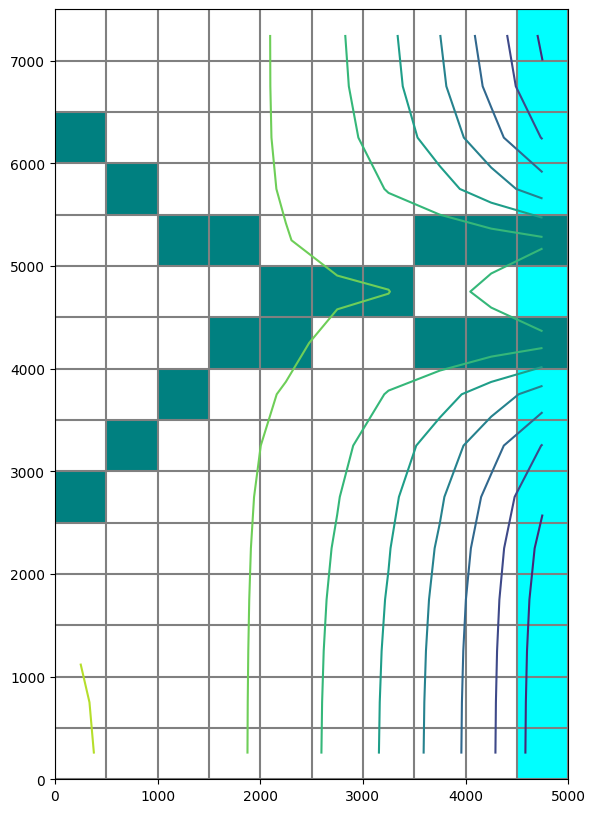

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

ghb_quadmesh = modelmap.plot_bc(name="ghb", plotAll=True)
riv_quadmesh = modelmap.plot_bc(name="riv", plotAll=True)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[0])

### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using FloPy methods.  The `MfGrdFile` class in FloPy can be used to read the binary grid file, which contains the cell connectivity (`ia` and `ja`).  The `output.budget()` method in FloPy can be used to read the binary budget file written by MODFLOW 6.

In [20]:
fname = os.path.join(workspace, "{}.dis.grb".format(model_name))
bgf = flopy.mf6.utils.MfGrdFile(fname)
ia, ja = bgf.ia, bgf.ja

In [21]:
flowja = gwf.output.budget().get_data(text="FLOW-JA-FACE")[0].squeeze()

In [22]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner. Note
# layer, row, column locations are zero-based.
k = 2
i = 11
j = 2
cell_nodes = gwf.modelgrid.get_node([(k, i, j)])

for celln in cell_nodes:
    print("Printing flows for cell {}".format(celln))
    for ipos in range(ia[celln] + 1, ia[celln + 1]):
        cellm = ja[ipos]
        print(
            "Cell {} flow with cell {} is {}".format(
                celln, cellm, flowja[ipos]
            )
        )

Printing flows for cell 412
Cell 412 flow with cell 262 is 251.46262091207623
Cell 412 flow with cell 402 is 0.7176346498656017
Cell 412 flow with cell 411 is 439.8629968543804
Cell 412 flow with cell 413 is -693.4212447574185
Cell 412 flow with cell 422 is 1.3779378787739915


### Post-Process Head Observations

MODFLOW 6 observations can be read using the `output.obs()` method in FloPy.

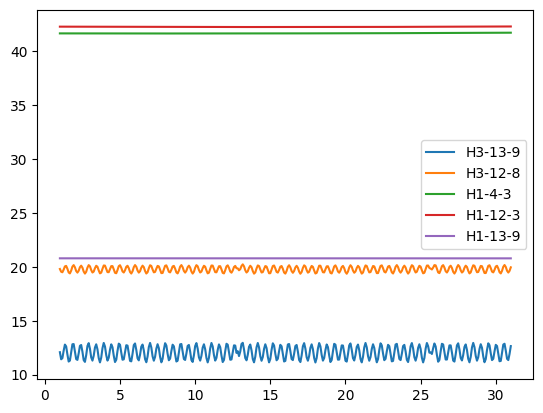

In [23]:
csv = gwf.head_obs.output.obs(f="head-hydrographs.csv").get_data()

for name in csv.dtype.names[1:]:
    plt.plot(csv["totim"], csv[name], label=name)
plt.legend();

In [24]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass